In [1]:
# %%capture
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.5 MB/s eta 0:00:00


In [2]:
#Mouting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [4]:
df = pd.read_csv('/content/drive/MyDrive/dataset/ChatbotCorpus.csv')
df.head()

,text,intent
0,i want to go marienplatz,FindConnection
1,when is the next train in muncher freiheit?,DepartureTime
2,when does the next u-bahn leaves from garching...,DepartureTime
3,from olympia einkaufszentrum to hauptbahnhof,FindConnection
4,when is the next train from winterstraße 12 to...,FindConnection


<Axes: xlabel='intent'>

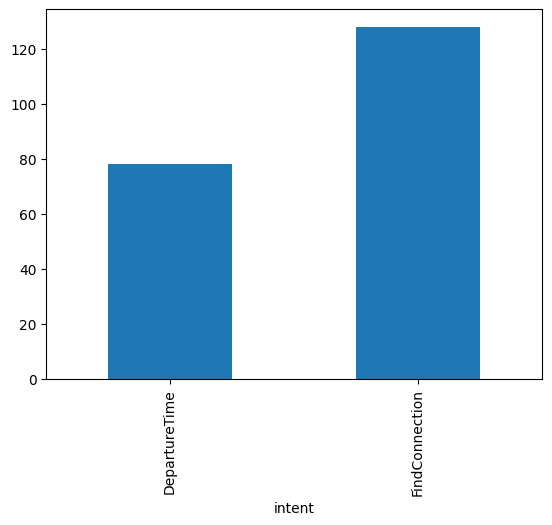

In [5]:
df.groupby(['intent']).size().plot.bar()

In [6]:
df['intent'].value_counts()

FindConnection    128
DepartureTime      78
Name: intent, dtype: int64

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {'FindConnection':0,
          'DepartureTime':1
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['intent']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [8]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [9]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [10]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [11]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

164 21 21


In [14]:
EPOCHS = 15
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 82/82 [00:17<00:00,  4.73it/s]


Epochs: 1 | Train Loss:  0.706 | Train Accuracy:  0.506 | Val Loss:  0.762 | Val Accuracy:  0.476


100%|██████████| 82/82 [00:17<00:00,  4.66it/s]


Epochs: 2 | Train Loss:  0.639 | Train Accuracy:  0.616 | Val Loss:  0.656 | Val Accuracy:  0.571


100%|██████████| 82/82 [00:16<00:00,  4.87it/s]


Epochs: 3 | Train Loss:  0.610 | Train Accuracy:  0.640 | Val Loss:  0.604 | Val Accuracy:  0.571


100%|██████████| 82/82 [00:16<00:00,  4.91it/s]


Epochs: 4 | Train Loss:  0.519 | Train Accuracy:  0.659 | Val Loss:  0.581 | Val Accuracy:  0.619


100%|██████████| 82/82 [00:16<00:00,  4.92it/s]


Epochs: 5 | Train Loss:  0.419 | Train Accuracy:  0.762 | Val Loss:  0.399 | Val Accuracy:  0.857


100%|██████████| 82/82 [00:16<00:00,  4.82it/s]


Epochs: 6 | Train Loss:  0.288 | Train Accuracy:  0.921 | Val Loss:  0.250 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.88it/s]


Epochs: 7 | Train Loss:  0.212 | Train Accuracy:  0.945 | Val Loss:  0.218 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.89it/s]


Epochs: 8 | Train Loss:  0.149 | Train Accuracy:  0.988 | Val Loss:  0.179 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.89it/s]


Epochs: 9 | Train Loss:  0.111 | Train Accuracy:  0.994 | Val Loss:  0.146 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.89it/s]


Epochs: 10 | Train Loss:  0.084 | Train Accuracy:  1.000 | Val Loss:  0.115 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.89it/s]


Epochs: 11 | Train Loss:  0.068 | Train Accuracy:  1.000 | Val Loss:  0.116 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.89it/s]


Epochs: 12 | Train Loss:  0.058 | Train Accuracy:  1.000 | Val Loss:  0.085 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.88it/s]


Epochs: 13 | Train Loss:  0.046 | Train Accuracy:  1.000 | Val Loss:  0.069 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.87it/s]


Epochs: 14 | Train Loss:  0.043 | Train Accuracy:  1.000 | Val Loss:  0.088 | Val Accuracy:  0.952


100%|██████████| 82/82 [00:16<00:00,  4.88it/s]


Epochs: 15 | Train Loss:  0.037 | Train Accuracy:  1.000 | Val Loss:  0.078 | Val Accuracy:  0.952


In [15]:
evaluate(model, df_test)

Test Accuracy:  0.905
